In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx

In [2]:
from featureExtraction import featureExtraction
# from bundle_adjustment import bundleAdjuster


In [3]:
def loadImages(img_dir):
    img_names = os.listdir(img_dir)
    img_list = []
    # Load images
    for img_name in img_names:
        img = cv.imread(img_dir + img_name)
        img_list.append(img)

    return img_list

    

In [4]:
img_dir = "./data/setSmall/"
img_list = loadImages(img_dir)


In [5]:
fe = featureExtraction(img_list.copy(),method="FLANN")

In [6]:
fe.run()

Extracting SIFT features...
Generating matches...
Processing matches...
Computing homographies...
Computing adjacency matrix...


#### Visualizing the network

In [7]:
def display_network(adjacency_matrix):
    G = nx.Graph(adjacency_matrix)
    nx.draw(G, with_labels=True, font_weight='bold')
    plt.show()

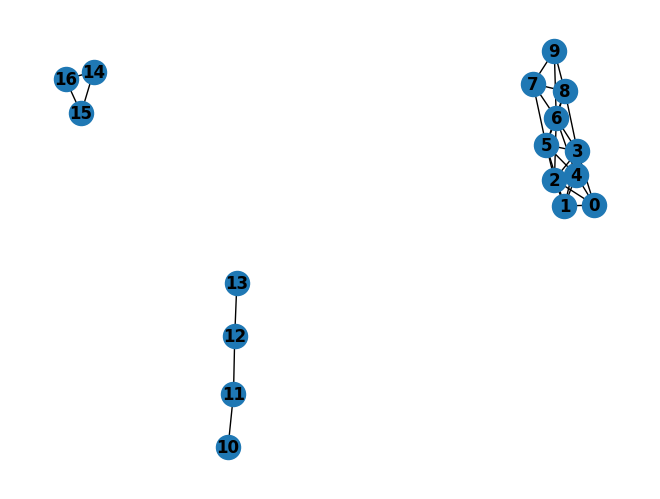

In [8]:
display_network(fe.adjacency_matrix)

In [91]:
# define the residual function
def get_diff(v1,v2):
        diff_v = []
        n = v1.shape[0]
        for i in range(n):
            x1 = v1[i][0][0]
            y1 = v1[i][0][1]
            x2 = v2[i][0][0]
            y2 = v2[i][0][1]
            val = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            diff_v.append(h(val))
        return np.array(diff_v)
    
def h(x):
    sigma = 5
    if x < sigma:
        return x**2
    else:
        return 2*sigma*x - sigma**2



def residual(H_init, src_pts_list, dst_pts_list):
    error = []
    for src_pts, dst_pts in zip(src_pts_list, dst_pts_list):
        dst_pts_pred = cv.perspectiveTransform(dst_pts, H_init.reshape(3,3))
        # take L2 norm of the difference between the predicted and actual points
        diff_vector = get_diff(dst_pts_pred, src_pts)
        # convert to 1D array
        error.extend(diff_vector)
    error = np.array(error)
    # print(error.shape)
    return error
    # dst_pts_ = cv.perspectiveTransform(dst_pts, H.reshape(3,3))
    # return (dst_pts_ - src_pts).reshape(-1)

In [151]:
import cv2 as cv
import numpy as np
import networkx as nx
import scipy.sparse.csgraph as csgraph
import scipy.optimize


class bundleAdjustment():

    def __init__(self,matches, numMatches, homographies, imgList,keypoints):
        self.matches = matches
        self.numMatches = numMatches
        self.homographies = homographies
        self.imgList = imgList
        self.kp = keypoints
        self.path = []
        self.paths = []
        self.bundleHomo = []
        self.initialHomo = []
        self.parents = []

    def bfs(self, G, node):

        # create a queue for bfs
        queue = []
        # mark all the nodes as not visited
        visited = [False] * len(self.imgList)
        # mark the source node as visited and enqueue it
        visited[node] = True
        queue.append(node)
        while queue:
            # dequeue a vertex from queue and print it
            s = queue.pop(0)
            self.path.append(s)
            # get adjacent vertices of the dequeued vertex s
            # if a adjacent has not been visited, then mark it visited and enqueue it
            for i in G.neighbors(s):
                if visited[i] == False:
                    visited[i] = True
                    queue.append(i)

    def buildNetwork(self):
        G = nx.Graph(self.numMatches)
        # create connected components
        connected_components = list(nx.connected_components(G))
        # if a connected component has just 1 node, it is a single image, remove it
        connected_components = [x for x in connected_components if len(x) > 1]
        num_connected_components = len(connected_components)
        print("Number of panoramas detected: ", num_connected_components)
        # for each connected compnent apply mst algorithm
        for i in range(num_connected_components):
            # get the connected component
            connected_component = connected_components[i]
            # get the subgraph of the connected component
            subgraph = G.subgraph(connected_component)
            # get the minimum spanning tree of the subgraph
            # get weights of the edges from numMatches
            mst = nx.minimum_spanning_tree(subgraph)
            #  plot the mst
            # nx.draw(mst, with_labels=True, font_weight='bold')
            # plt.show()
            # find the node that has maximum number of matches with its neighbors
            # get the nodes of the mst
            nodes = list(mst.nodes())
            mode = "degree"
            max_matches = 0
            max_degree = 0
            index_node = 0
            if mode == "degree":
                for j in range(len(nodes)):
                    # get the degree of the node
                    degree = mst.degree(nodes[j])
                    if degree > max_degree:
                        max_degree = degree
                        index_node = j
            elif mode == "matches":
                for j in range(len(nodes)):
                    # check matches between with the neighboring nodes
                    # get neighbors of the node
                    neighbors = list(mst.neighbors(nodes[j]))
                    # get the number of matches between the node and its neighbors
                    num_matches = 0
                    for neighbor in neighbors:
                        num_matches += self.numMatches[nodes[j]][neighbor]
                    if num_matches > max_matches:
                        max_matches = num_matches
                        index_node = j

            # apply dfs from the node with maximum number of matches
            # print(index_node, nodes[index_node])
            src = nodes[index_node]
            parents = nx.predecessor(mst, src)
            self.parents.append(parents)
            self.bfs(mst, nodes[index_node])
            self.paths.append(self.path)
            self.path = []

    def homography_to_src(self,cur,parent):
        H = np.eye(3)
        while len(parent[cur]) != 0:
            par = parent[cur][0]
            if self.homographies[cur][par] is None:
                print("No homography between ", cur, " and ", par)
            else: 
                H = np.matmul(self.homographies[cur][par],H)
            cur = par
        return H


    def bundleAdjuster(self, path, parent):
        # start with the first image, its homography is identity
        H_init = np.eye(3)
        # for every match between img[path[i]] and img[path[i+1]], compute residual
        # and update homography
        ba=[path[0]]
        ordered_H = []
        initial_H = []
        for i in range(1,len(path)):
            # get the matches between img[path[i]] and img[path[i+1]]
            src_pts_list = []
            dst_pts_list = []

            # estimate homography
            

            
            for j in ba:
                matches = self.matches[j][path[i]]
                if matches is None:
                    # print("No matches between ", j, " and ", path[i])
                    continue
                # get the homography between img[path[i]] and img[path[i+1]]
                # get the coordinates of the matched points
                # get the coordinates of the matched points in img[path[i]]
                src_pts = np.float32([self.kp[j][m.queryIdx].pt for m in matches]).reshape(-1,1,2)
                H_temp = self.homography_to_src(j,parent)
                src_pts_transformed = cv.perspectiveTransform(src_pts, H_temp)
                src_pts_list.append(src_pts_transformed)
                # get the coordinates of the matched points in img[path[i+1]]
                dst_pts = np.float32([self.kp[path[i]][m.trainIdx].pt for m in matches]).reshape(-1,1,2)
                dst_pts_list.append(dst_pts)
                # optimize the residual function using the Levenberg-Marquardt algorithm

            
            H_init = self.homography_to_src(path[i],parent)
            initial_H.append(H_init.reshape(3,3))
            H_init = H_init.flatten()
            result = scipy.optimize.least_squares(residual, H_init, args=(src_pts_list, dst_pts_list), method='lm')
            # update the homography
            H = result.x.reshape(3,3)
            # normalize the homography
            H = H/H[2,2]
            ordered_H.append(H)
            ba.append(path[i])

        return ordered_H, initial_H
            

    
    def run(self):
        print("Building network and ordering...")
        self.buildNetwork()
        # return
        print("Performing bundle adjustment for each panorama...")
        for i in range(len(self.paths)):
            print("Panorama ",i+1)
            ordered_H, initial_H = self.bundleAdjuster(self.paths[i], self.parents[i])
            self.bundleHomo.append(ordered_H)
            self.initialHomo.append(initial_H)
        print("Completed bundle adjustment for all panoramas")
    


In [152]:
matches=fe.matches.copy()
homographies=fe.homographies.copy()
images=fe.image_list.copy()
adjacency_matrix=fe.adjacency_matrix.copy()
numMatches=np.zeros((len(img_list),len(img_list)))
for i in range(len(img_list)):
    for j in range(len(img_list)):
        if fe.matches[i][j]==None:
            numMatches[i,j]=0
            continue
        numMatches[i,j]=-len(fe.matches[i][j]) # we take -ve wts as we want to retain the edges with more matches while applying MST
BA=bundleAdjustment(matches,numMatches,homographies,images,fe.keypoints)
BA.run()

Building network and ordering...
Number of panoramas detected:  3
Performing bundle adjustment for each panorama...
Panorama  1
Panorama  2
Panorama  3
Completed bundle adjustment for all panoramas


In [136]:
BA.paths

[[8, 7, 6, 9, 5, 3, 4, 2, 1, 0], [11, 10, 12, 13], [15, 16, 14]]

In [137]:
BA.parents

[{8: [],
  7: [8],
  6: [8],
  9: [8],
  5: [6],
  3: [5],
  4: [3],
  2: [4],
  1: [2],
  0: [1]},
 {11: [], 10: [11], 12: [11], 13: [12]},
 {15: [], 16: [15], 14: [15]}]

Stitching successful


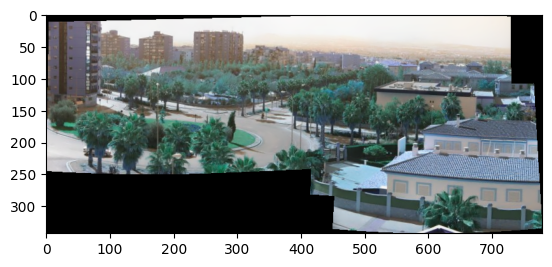

In [121]:
# use cv.sticher to stitch the images
stitcher = cv.Stitcher_create()
# get the images in the order of the path
images = []
for i in range(len(BA.paths[0])):
    images.append(img_list[BA.paths[0][i]])
# stitch the images
status, result = stitcher.stitch(images)
# check if the stitching was successful
if status == cv.Stitcher_OK:
    print("Stitching successful")
    plt.imshow(result)
    plt.show()
else:
    print("Stitching failed")

Stitching successful


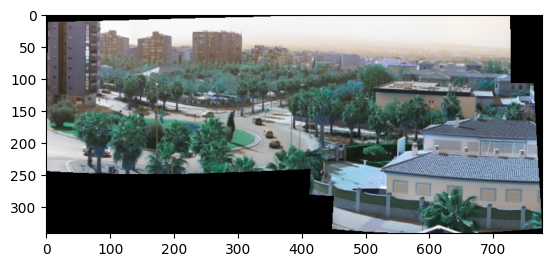

In [34]:
# use cv.sticher to stitch the images
stitcher = cv.Stitcher_create()
# get the images in the order of the path
idx = [0,8,1,7,2,6,3,5,4,9]
images = []
for i in idx:
    images.append(img_list[i])
# stitch the images
status, result = stitcher.stitch(images)
# check if the stitching was successful
if status == cv.Stitcher_OK:
    print("Stitching successful")
    plt.imshow(result)
    plt.show()
else:
    print("Stitching failed")

In [148]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

def stitch_images(image1,image2,H):
    width = 2*image1.shape[1] + image2.shape[1]
    height = 2*image1.shape[0] + image2.shape[0]

    # offset Homography by width and height of first image
    offset_matrix = np.eye(3)
    offset_matrix[0][2] = image1.shape[1]
    offset_matrix[1][2] = image1.shape[0]
    H_new = offset_matrix @ H
    result = cv.warpPerspective(image1, H_new, (width, height))
    result[image1.shape[0]:image2.shape[0]+image1.shape[0], image1.shape[1]:image2.shape[1]+image1.shape[1]] = image2

    return trim(result)



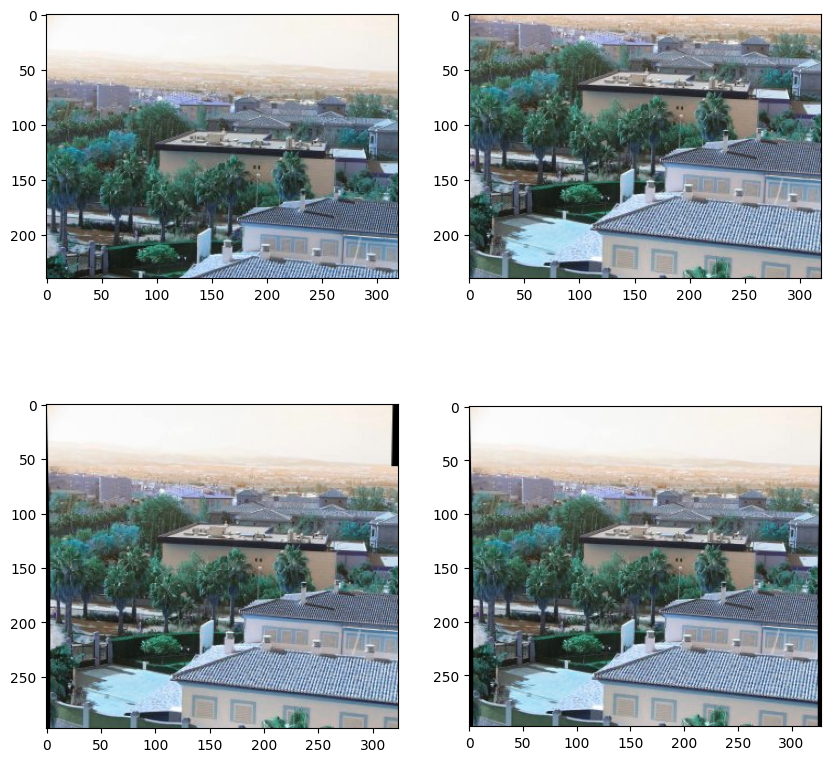

In [64]:
img1 = img_list[7]
img2 = img_list[8]
H = BA.bundleHomo[0][0]
H_1 = fe.homographies[7][8]
s = stitch_images(img1,img2,H)
s_1 = stitch_images(img1,img2,H_1)

ax, fig = plt.subplots(2,2,figsize=(10,10))
fig[0,0].imshow(img1)
fig[0,1].imshow(img2)
fig[1,0].imshow(s)
fig[1,1].imshow(s_1)

In [ ]:
img1 = img_list[5]
img2 = img_list[8]
H = BA.bundleHomo[0][0]
H_1 = fe.homographies[7][8]
s = stitch_images(img1,img2,H)
s_1 = stitch_images(img1,img2,H_1)

ax, fig = plt.subplots(2,2,figsize=(10,10))
fig[0,0].imshow(img1)
fig[0,1].imshow(img2)
fig[1,0].imshow(s)
fig[1,1].imshow(s_1)

In [65]:
def stitch_images2(image1,image2,image3,H12, H23):

    offsetx = image2.shape[1] + image3.shape[1]
    offsety = image2.shape[0] + image3.shape[0]

    width = 2*(offsetx) + image1.shape[1]
    height = 2*(offsety) + image1.shape[0]

    # offset Homography by width and height of first image
    offset_matrix = np.eye(3)
    offset_matrix[0][2] = offsetx
    offset_matrix[1][2] = offsety
    H_new12 = offset_matrix @ H12
    H_new23 = offset_matrix @ H23
    result1 = cv.warpPerspective(image2, H_new12, (width, height))
    result2 = cv.warpPerspective(image3, H_new23, (width, height))
    result1[offsety:offsety+image1.shape[0], offsetx:offsetx+image1.shape[1]] = image1
    result2[offsety:offsety+image1.shape[0], offsetx:offsetx+image1.shape[1]] = image1
    result = cv.addWeighted(result1,0.5,result2,0.5,0)
    return trim(result)

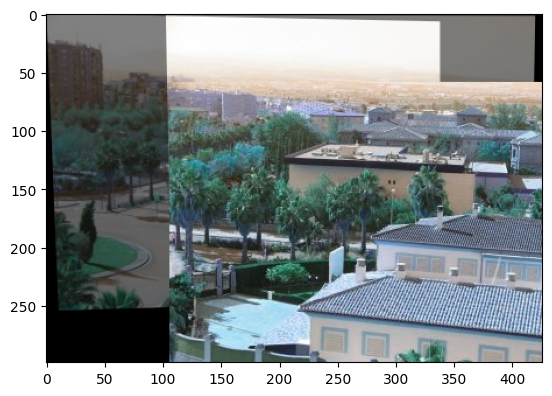

In [144]:
i1 = img_list[8]
i2 = img_list[7]
i3 = img_list[5]
H12 = BA.bundleHomo[0][0]
H23 = BA.bundleHomo[0][1]
s = stitch_images2(i1,i2,i3,H12,H23)

plt.imshow(s)

[8, 7, 6, 9, 5, 3, 4, 2, 1, 0]


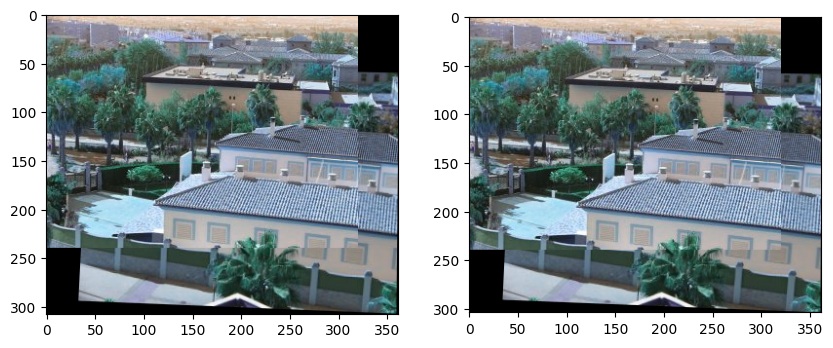

In [127]:
H_1 = BA.bundleHomo[0][2]
H_2 = BA.initialHomo[0][2]
print(BA.paths[0])
s3 = stitch_images(i3,i1,H_1)
s4 = stitch_images(i3,i1,H_2)
ax, fig = plt.subplots(1,2,figsize=(10,10))
fig[0].imshow(s3)
fig[1].imshow(s4)

[8, 7, 6, 9, 5, 3, 4, 2, 1, 0]


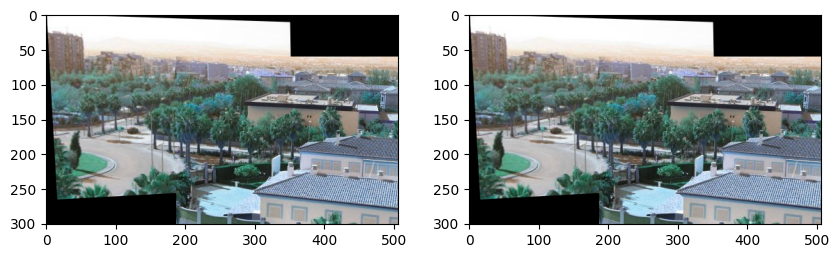

In [153]:
H_1 = BA.bundleHomo[0][3]
H_2 = BA.initialHomo[0][3]
print(BA.paths[0])
s3 = stitch_images(i3,i1,H_1)
s4 = stitch_images(i3,i1,H_2)
ax, fig = plt.subplots(1,2,figsize=(10,10))
fig[0].imshow(s3)
fig[1].imshow(s4)

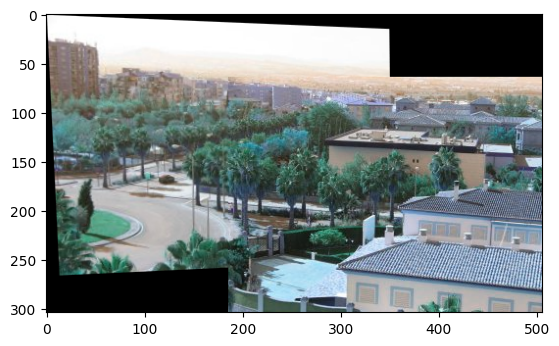

In [150]:
H = fe.homographies[5][6] @ fe.homographies[6][8]
s_temp = stitch_images(img_list[5],img_list[8],H)
plt.imshow(s_temp)